In [100]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn import metrics
from statsmodels.tsa.api import Holt
import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import prepare

Split data (train/test) and resample by any period, except daily, and aggregate using the sum.\
Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:\
Simple Average\
Moving Average\
Holt's Linear Trend Model\
Based on previous year/month/etc., this is up to you.

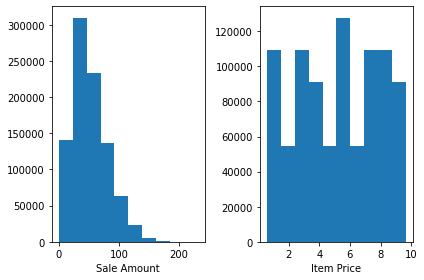

In [3]:
df = prepare.prepare_store_data()

In [4]:
df.head(2)

,item_id,sale_amount,sale_id,store_id,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14,day_of_week,month,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Tuesday,1,10.92
2013-01-01 00:00:00+00:00,12,26.0,211817,7,12018 Perrin Beitel Rd,San Antonio,TX,78217,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,Tuesday,1,218.40


In [33]:
forecast_df = df[['sale_amount', 'sales_total']].rename(columns = {'sale_amount':'items_sold', 'sales_total':'dollars_sold'})

In [34]:
forecast_df = forecast_df.resample('W').sum()

In [35]:
forecast_df.head(2)

,items_sold,dollars_sold
sale_date,,
2013-01-06 00:00:00+00:00,91067.0,490767.50
2013-01-13 00:00:00+00:00,103902.0,559934.21


In [43]:
train_prop = 0.66
train_size = int(len(forecast_df) * train_prop)
train, test = forecast_df[0:train_size], forecast_df[train_size:len(forecast_df)]

In [44]:
train.shape, test.shape

((172, 2), (89, 2))

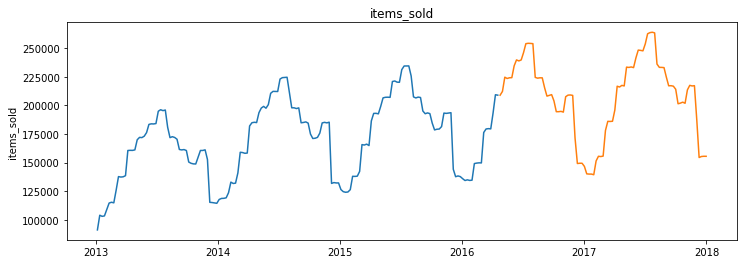

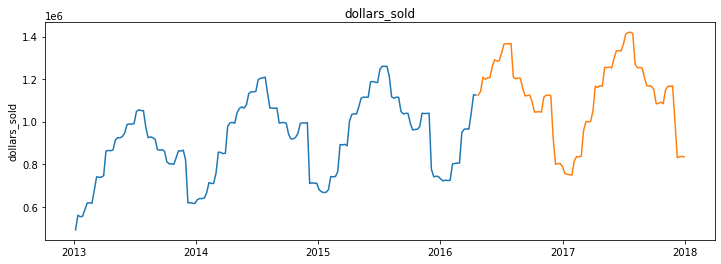

In [45]:
for cols in train.columns:
    plt.figure(figsize = (12,4))
    plt.plot(train[cols])
    plt.plot(test[cols])
    plt.ylabel(cols)
    plt.title(cols)
    plt.show()

In [65]:
def evaluate(target_var):
    mse = metrics.mean_squared_error(test[target_var],yhat_df[target_var])
    rmse = round(math.sqrt(mse),0)
    return rmse

In [56]:
def plot_and_eval(target_var):
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var],label = 'train')
    plt.plot(test[target_var], label = 'test')
    plt.plot(yhat_df[target_var], label = 'predicted')
    rmse = evaluate(target_var)
    print((target_var, '-- RMSE: {:.0f}'.format(rmse)))
    plt.show()

In [57]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

#### Simple Average

In [58]:
items = round(train['items_sold'].mean(), 0)
dollars = round(train['dollars_sold'].mean(),0)

In [59]:
items, dollars

(169422.0, 910902.0)

In [60]:
yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, index = test.index)

In [61]:
yhat_df.head(2)

,items_sold,dollars_sold
sale_date,,
2016-04-24 00:00:00+00:00,169422.0,910902.0
2016-05-01 00:00:00+00:00,169422.0,910902.0
2016-05-08 00:00:00+00:00,169422.0,910902.0
2016-05-15 00:00:00+00:00,169422.0,910902.0
2016-05-22 00:00:00+00:00,169422.0,910902.0


('items_sold', '-- RMSE: 51876')


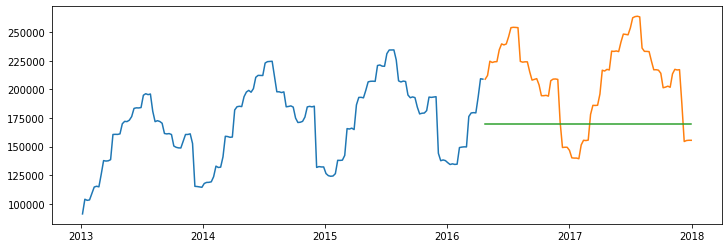

('dollars_sold', '-- RMSE: 278676')


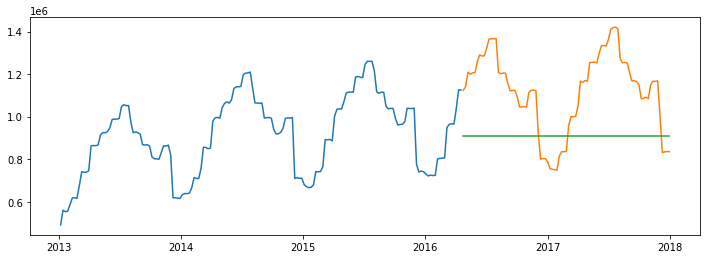

In [66]:
for cols in train.columns:
    plot_and_eval(cols)

#### Moving Average

In [85]:
# lets use 30 day rolling average 
period = 4
items = round(train['items_sold'].rolling(period).mean().iloc[-1],0)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1],0)

In [86]:
items, dollars

(197788.0, 1063613.0)

In [87]:
yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, index = test.index)

In [88]:
yhat_df.head(2)

,items_sold,dollars_sold
sale_date,,
2016-04-24 00:00:00+00:00,197788.0,1063613.0
2016-05-01 00:00:00+00:00,197788.0,1063613.0


('items_sold', '-- RMSE: 35694')


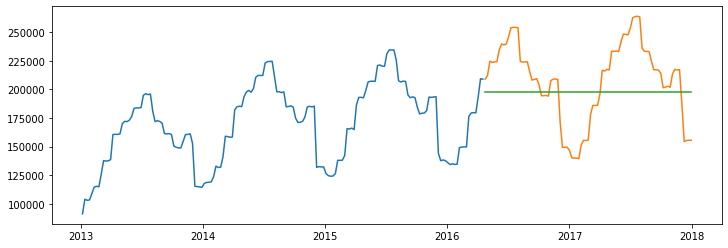

('dollars_sold', '-- RMSE: 191718')


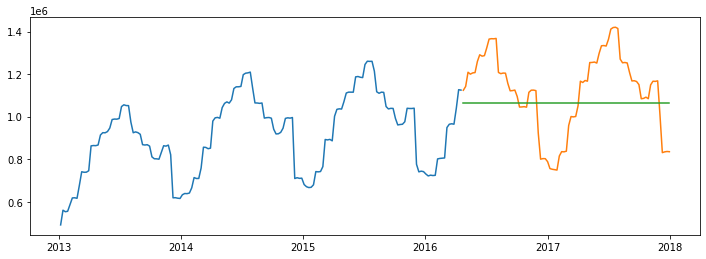

In [89]:
for cols in train.columns:
    plot_and_eval(cols)

1  rolling period(s), rmse =  34024.0
2  rolling period(s), rmse =  34026.0
4  rolling period(s), rmse =  35694.0
8  rolling period(s), rmse =  41674.0
12  rolling period(s), rmse =  50260.0


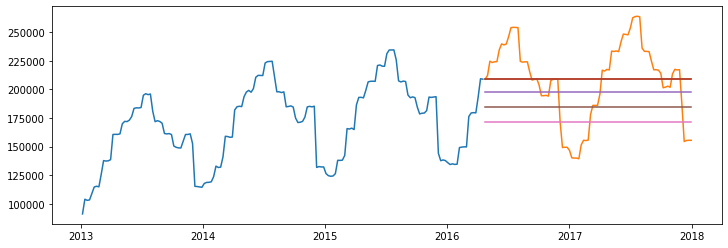

1  rolling period(s), rmse =  182900.0
2  rolling period(s), rmse =  182921.0
4  rolling period(s), rmse =  191718.0
8  rolling period(s), rmse =  223674.0
12  rolling period(s), rmse =  269904.0


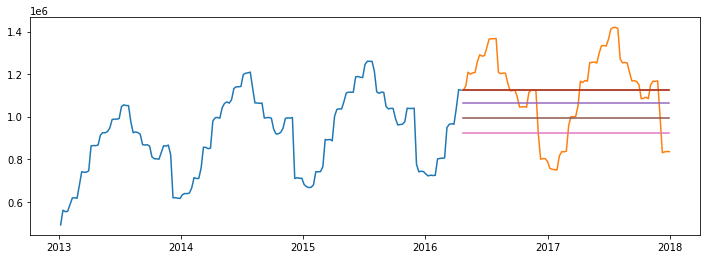

In [99]:
for cols in train.columns:
    
    plt.figure(figsize=(12, 4))
    plt.plot(train[cols],label = 'train')
    plt.plot(test[cols], label = 'test')
    periods = [1, 2,4,8,12]
    for period in periods:
        yhat_df[cols] = train[cols].rolling(period).mean().iloc[-1]
        rmse = evaluate(cols)
        plt.plot(yhat_df[cols])
        print(period, " rolling period(s), rmse = ", evaluate(cols))
    plt.show()

#### Holt's Linear Trend Model

In [151]:
model = Holt(train['items_sold'])
model = model.fit(smoothing_level=.11, smoothing_slope=.1, optimized=False)
yhat_items = model.predict(start = test.index[0], end = test.index[-1] )
yhat_df['items_sold'] = round(yhat_items,0)

In [162]:
model = Holt(train['dollars_sold'])
model = model.fit(smoothing_level=.12, smoothing_slope=.1, optimized=False)
yhat_dollars = model.predict(start = test.index[0], end = test.index[-1])
yhat_df['dollars_sold'] = round(yhat_dollars,0)

('items_sold', '-- RMSE: 48986')


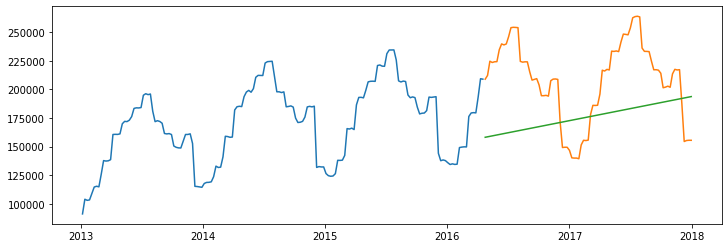

('dollars_sold', '-- RMSE: 231144')


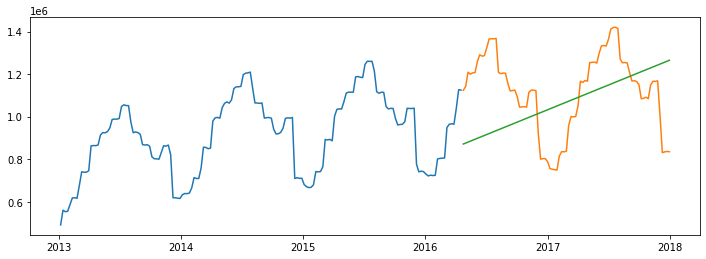

In [163]:
for cols in train.columns:
    plot_and_eval(cols)